# Objective

For this project, we are trying to use convolutional neural networks to try to identify the ESRB rating of video games based on images from the game. This could have applications in live content moderation on platforms such as Twitch or YouTube, where a streamer might be streaming games with mature content without identifying their stream as containing mature content. If we can train a CNN to identify mature content or at least flag that content for human review, we can help reduce the amount of content that human reviewers would have to sift through. We could also hopefully identify a greater amount of mature content without the need of user reporting, ideally leading to less consumption by young audiences before the content is reported.

# Obtain

In [1]:
# Imports
import pandas as pd

First, we want a list of games and their respective ratings. We'll pull that information from the ESRB website, and we'll use games released for the PlayStation 4, Xbox One, and Nintendo Switch. The notebook 'data_scrape_titles' details the process of scraping the information using Selenium. A pandas DataFrame containing the data is saved as 'esrb_ratings.pkl'.

In [2]:
df = pd.read_pickle('esrb_ratings.pkl')
df.head()

title  \
0            Blizzard Arcade Collection   
1                          Rez Infinite   
2                        Hotshot Racing   
3  Sea of Solitude : The Director's Cut   
4                               Ape Out   

                                     consoles  \
0  [PlayStation 4, Nintendo Switch, Xbox One]   
1                             [PlayStation 4]   
2            [PlayStation 4, Nintendo Switch]   
3                           [Nintendo Switch]   
4                           [Nintendo Switch]   

                                         descriptors   rating  
0  [Blood, Fantasy Violence, Language, Use of Tob...        T  
1                                 [Fantasy Violence]  E10plus  
2       [Alcohol Reference, Language, Mild Violence]  E10plus  
3                       [Fantasy Violence, Language]        T  
4                         [Blood and Gore, Violence]        T

With this data, we'll use Selenium once again to go through the game titles and pull 10 images of each game from Google Images. This process is detailed in the notebook 'data_scrape_images'. After running the notebook, the images are saved in an 'images' directory, with each image being saved in a subdirectory corresponding to the game's rating.

# Scrub

With our images gathered and sorted, we then run the code in the notebook 'data_split' to split our images into training, validation, and test sets. We do two different splits. In the first split, the game images are sorted according to the specific ratings of their games(E, E10plus, M, T). In the second split, The game images are sorted into groups of E-T and M.

![Image Folder](project_images/images_folder.png)

The first will allow us to do a 4-class categorical classification. The second will allow us to do a binary classification. Our main goal is to identify M-rated games, and we'll have to see whether a categorical or binary model is better-equipped to do that.

# Explore

In [3]:
# Imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
%matplotlib inline

import my_module as custom

C:\Users\katma\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


To get a feel for the data, we'll create some image generators, and then use that to check out some of our training images.

In [4]:
# Create generators
train_data = ImageDataGenerator(rescale=1/255,
                                horizontal_flip=True,
                                shear_range=0.2,
                                zoom_range=0.2)
val_data = ImageDataGenerator(rescale=1/255)
test_data = ImageDataGenerator(rescale=1/255)

In [5]:
train_gen = train_data.flow_from_directory('images/train', target_size=(224,224))
val_gen = val_data.flow_from_directory('images/val', target_size=(224,224))
test_gen = test_data.flow_from_directory('images/test', target_size=(224,224), shuffle=False)

Found 33620 images belonging to 4 classes.
Found 2240 images belonging to 4 classes.
Found 8970 images belonging to 4 classes.


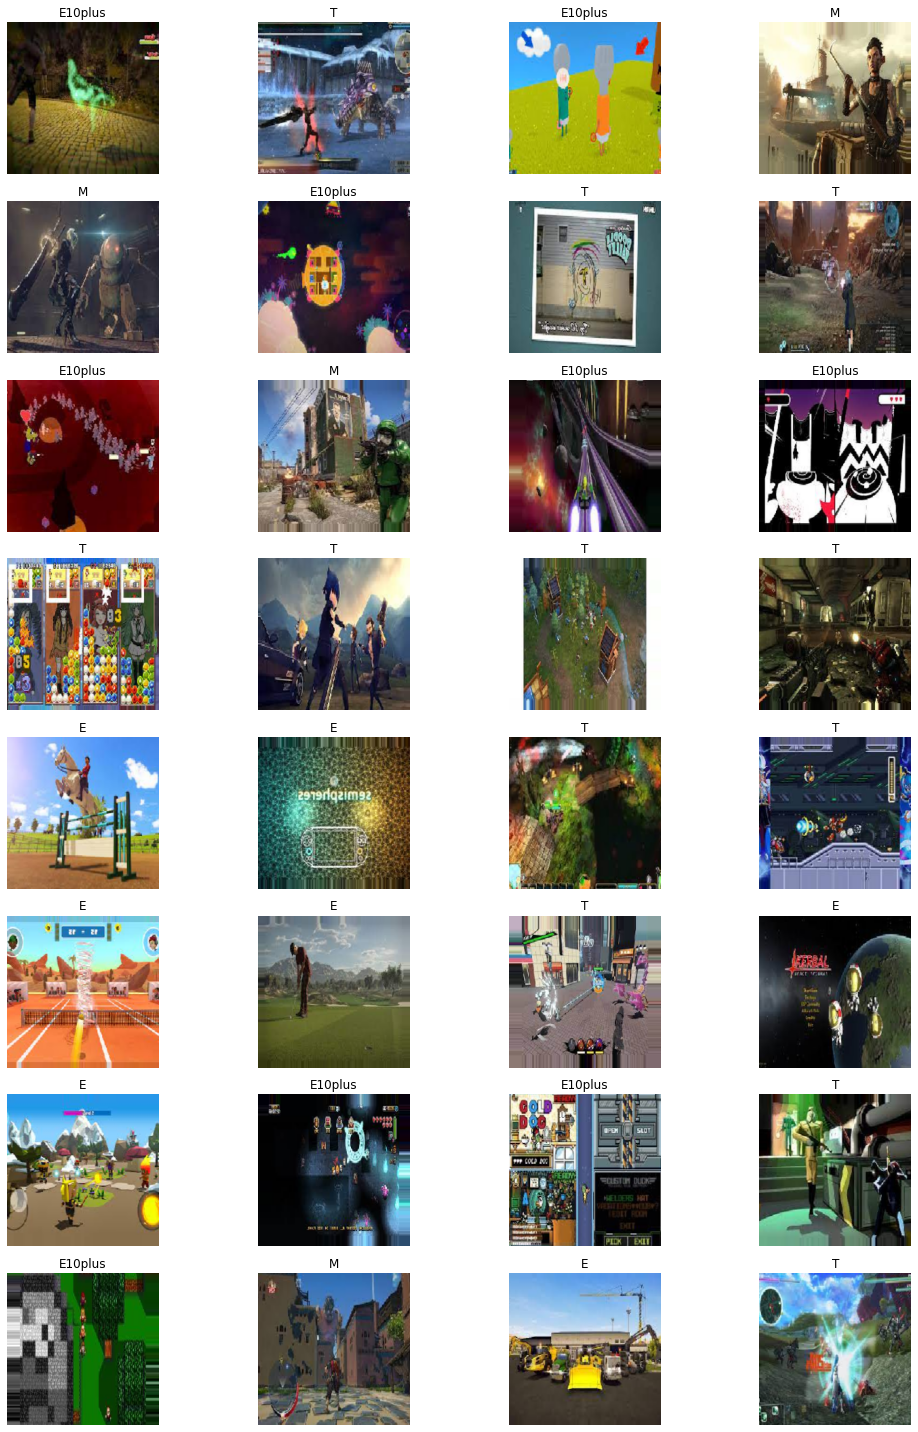

In [6]:
# Get a batch of images
img, labels = train_gen.next()
ratings = ['E', 'E10plus', 'M', 'T']

# Show the images and labels
plt.figure(figsize=(15,20))
for i in range(len(img)):
    plt.subplot(8,4,i+1)
    plt.title(ratings[labels[i].argmax()])
    plt.imshow(img[i])
    plt.axis('off')
plt.tight_layout()

Upon viewing this batch of images, I would not personally be able to accurately label many of the games just based on the given image. Hopefully our neural networks can pick out features that are not obvious to me.

# Model

In [7]:
# Imports
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint

In [8]:
def init_callbacks(number):
    model_checkpoint = ModelCheckpoint(f'best_model_{str(number)}.h5', monitor='val_loss',
                                       verbose=1, save_best_only=True,
                                       save_weights_only=True)
    return model_checkpoint

input_shape = (224,224,3)

## Model 1 (Simple Neural Network)

In [9]:
model_1 = Sequential()
model_1.add(Dense(128, activation='relu', input_shape=input_shape))
model_1.add(Dense(64, activation='relu'))
model_1.add(Flatten())
model_1.add(Dense(4, activation='softmax'))

model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
                metrics=['acc'])

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 224, 224, 128)     512       
_________________________________________________________________
dense_1 (Dense)              (None, 224, 224, 64)      8256      
_________________________________________________________________
flatten (Flatten)            (None, 3211264)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 12845060  
Total params: 12,853,828
Trainable params: 12,853,828
Non-trainable params: 0
_________________________________________________________________


In [10]:
history_1 = model_1.fit(train_gen,
                        steps_per_epoch=100,
                        epochs=10,
                        validation_data=val_gen,
                        callbacks=init_callbacks(1))

Epoch 1/10
100/100 [==============================] - 34s 325ms/step - loss: 4.7813 - acc: 0.2764 - val_loss: 1.6295 - val_acc: 0.2996

Epoch 00001: val_loss improved from inf to 1.62952, saving model to best_model_1.h5
Epoch 2/10
100/100 [==============================] - 31s 309ms/step - loss: 1.5378 - acc: 0.3570 - val_loss: 1.3338 - val_acc: 0.3781

Epoch 00002: val_loss improved from 1.62952 to 1.33385, saving model to best_model_1.h5
Epoch 3/10
100/100 [==============================] - 31s 304ms/step - loss: 1.3142 - acc: 0.3829 - val_loss: 1.3232 - val_acc: 0.3763

Epoch 00003: val_loss improved from 1.33385 to 1.32319, saving model to best_model_1.h5
Epoch 4/10
100/100 [==============================] - 30s 302ms/step - loss: 1.2871 - acc: 0.3932 - val_loss: 1.3273 - val_acc: 0.3746

Epoch 00004: val_loss did not improve from 1.32319
Epoch 5/10
100/100 [==============================] - 30s 303ms/step - loss: 1.2697 - acc: 0.4180 - val_loss: 1.3200 - val_acc: 0.3723

Epoch 000

281/281 [==============================] - 21s 76ms/step - loss: 1.2947 - acc: 0.4078
[1.2946959733963013, 0.40780380368232727]


C:\Users\katma\course_materials\capstone-project\my_module.py:20: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks(range(1,(len(history['acc']))+1),5)
C:\Users\katma\course_materials\capstone-project\my_module.py:25: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks(range(1,(len(history['loss']))+1),5)


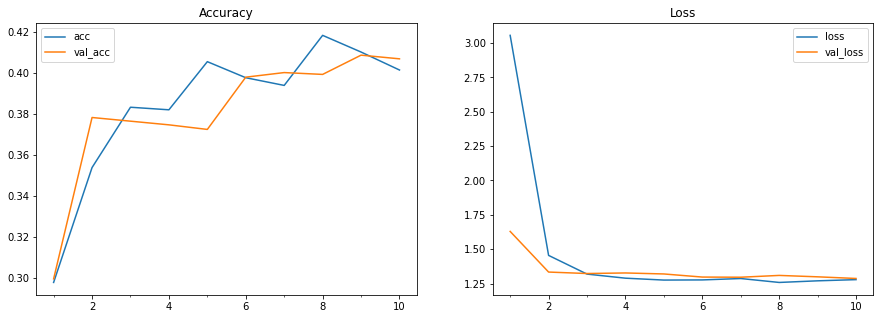

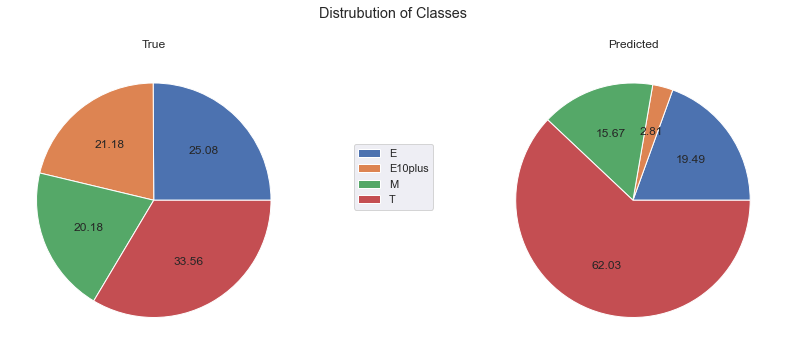

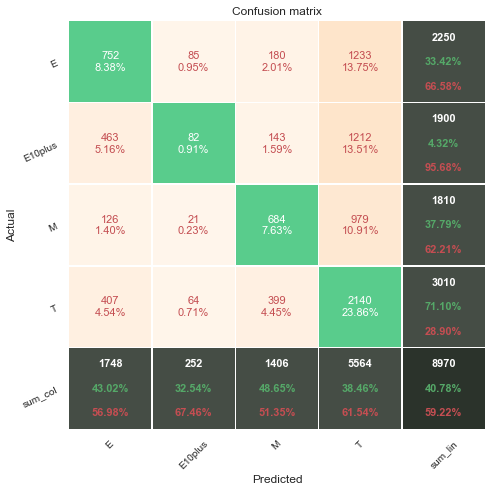

              precision    recall  f1-score   support

           E       0.43      0.33      0.38      2250
     E10plus       0.33      0.04      0.08      1900
           M       0.49      0.38      0.43      1810
           T       0.38      0.71      0.50      3010

    accuracy                           0.41      8970
   macro avg       0.41      0.37      0.34      8970
weighted avg       0.40      0.41      0.36      8970



<Figure size 432x288 with 0 Axes>

In [11]:
custom.evaluate(model_1, history_1, test_gen)

## Model 2 (CNN - 4 Convolutional Blocks)

In [12]:
model_2 = Sequential()

model_2.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',
                  activation='relu', input_shape=input_shape))
model_2.add(Conv2D(32, (3,3), activation='relu'))
model_2.add(MaxPooling2D((2,2)))
model_2.add(Dropout(0.2))

model_2.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model_2.add(Conv2D(64, (3,3), activation='relu'))
model_2.add(MaxPooling2D((2,2)))
model_2.add(Dropout(0.2))

model_2.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model_2.add(Conv2D(128, (3,3), activation='relu'))
model_2.add(MaxPooling2D((2,2)))
model_2.add(Dropout(0.2))

model_2.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model_2.add(Conv2D(256, (3,3), activation='relu'))
model_2.add(MaxPooling2D((2,2)))
model_2.add(Dropout(0.2))

model_2.add(Flatten())
model_2.add(Dense(512, activation='relu'))
model_2.add(Dropout(0.2))
model_2.add(Dense(4, activation='softmax'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4)

model_2.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 111, 111, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)       

In [13]:
history_2 = model_2.fit(train_gen,
                        epochs=10,
                        validation_data=val_gen,
                        callbacks=init_callbacks(2))

Epoch 1/10
1051/1051 [==============================] - 277s 258ms/step - loss: 1.3246 - acc: 0.3585 - val_loss: 1.2601 - val_acc: 0.4152

Epoch 00001: val_loss improved from inf to 1.26011, saving model to best_model_2.h5
Epoch 2/10
1051/1051 [==============================] - 266s 253ms/step - loss: 1.2506 - acc: 0.4093 - val_loss: 1.4137 - val_acc: 0.3411

Epoch 00002: val_loss did not improve from 1.26011
Epoch 3/10
1051/1051 [==============================] - 261s 248ms/step - loss: 1.2347 - acc: 0.4252 - val_loss: 1.2246 - val_acc: 0.4277

Epoch 00003: val_loss improved from 1.26011 to 1.22456, saving model to best_model_2.h5
Epoch 4/10
1051/1051 [==============================] - 262s 249ms/step - loss: 1.2138 - acc: 0.4405 - val_loss: 1.2495 - val_acc: 0.4187

Epoch 00004: val_loss did not improve from 1.22456
Epoch 5/10
1051/1051 [==============================] - 261s 249ms/step - loss: 1.1986 - acc: 0.4480 - val_loss: 1.2101 - val_acc: 0.4496

Epoch 00005: val_loss improved 

281/281 [==============================] - 12s 42ms/step - loss: 1.1869 - acc: 0.4702
[1.186927080154419, 0.47023412585258484]


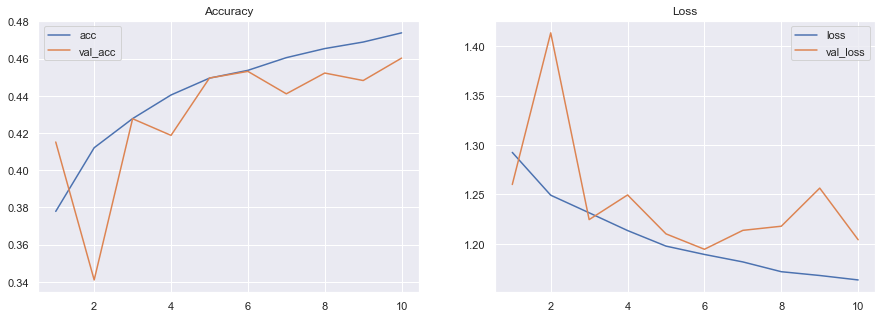

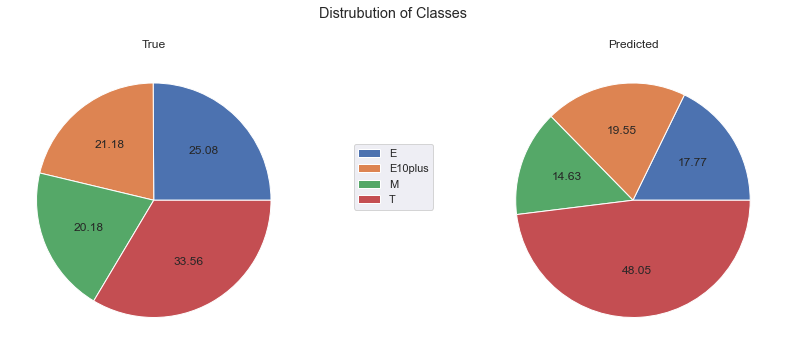

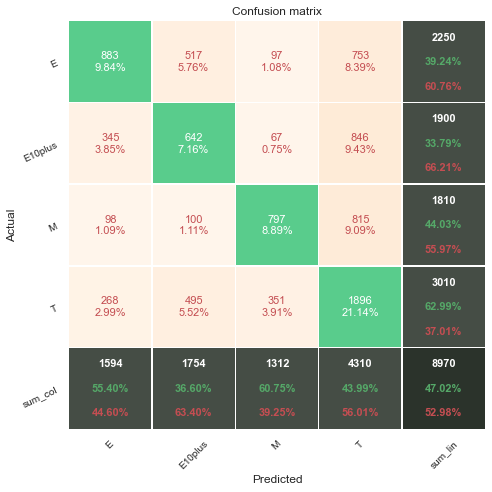

              precision    recall  f1-score   support

           E       0.55      0.39      0.46      2250
     E10plus       0.37      0.34      0.35      1900
           M       0.61      0.44      0.51      1810
           T       0.44      0.63      0.52      3010

    accuracy                           0.47      8970
   macro avg       0.49      0.45      0.46      8970
weighted avg       0.49      0.47      0.47      8970



<Figure size 432x288 with 0 Axes>

In [14]:
custom.evaluate(model_2, history_2, test_gen)

## Model 3 (With Batch Normalization)

In [15]:
model_3 = Sequential()

model_3.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',
                  activation='relu', input_shape=input_shape))
model_3.add(Conv2D(32, (3,3), activation='relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D((2,2)))
model_3.add(Dropout(0.2))

model_3.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model_3.add(Conv2D(64, (3,3), activation='relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D((2,2)))
model_3.add(Dropout(0.2))

model_3.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model_3.add(Conv2D(128, (3,3), activation='relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D((2,2)))
model_3.add(Dropout(0.2))

model_3.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model_3.add(Conv2D(256, (3,3), activation='relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D((2,2)))
model_3.add(Dropout(0.2))

model_3.add(Flatten())
model_3.add(Dense(512, activation='relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(4, activation='softmax'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4)

model_3.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 222, 222, 32)      9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 111, 111, 64)      18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 109, 109, 64)     

In [16]:
history_3 = model_3.fit(train_gen,
                        epochs=10,
                        validation_data=val_gen,
                        callbacks=init_callbacks(3))

Epoch 1/10
1051/1051 [==============================] - 265s 251ms/step - loss: 1.8380 - acc: 0.3356 - val_loss: 1.6789 - val_acc: 0.3210

Epoch 00001: val_loss improved from inf to 1.67888, saving model to best_model_3.h5
Epoch 2/10
1051/1051 [==============================] - 263s 250ms/step - loss: 1.2998 - acc: 0.3940 - val_loss: 1.5897 - val_acc: 0.3719

Epoch 00002: val_loss improved from 1.67888 to 1.58969, saving model to best_model_3.h5
Epoch 3/10
1051/1051 [==============================] - 266s 253ms/step - loss: 1.2729 - acc: 0.4090 - val_loss: 1.3926 - val_acc: 0.3978

Epoch 00003: val_loss improved from 1.58969 to 1.39260, saving model to best_model_3.h5
Epoch 4/10
1051/1051 [==============================] - 263s 250ms/step - loss: 1.2571 - acc: 0.4149 - val_loss: 1.8544 - val_acc: 0.3964

Epoch 00004: val_loss did not improve from 1.39260
Epoch 5/10
1051/1051 [==============================] - 264s 251ms/step - loss: 1.2508 - acc: 0.4257 - val_loss: 1.7966 - val_acc: 0.

281/281 [==============================] - 32s 113ms/step - loss: 1.3754 - acc: 0.4562
[1.3753552436828613, 0.45618727803230286]


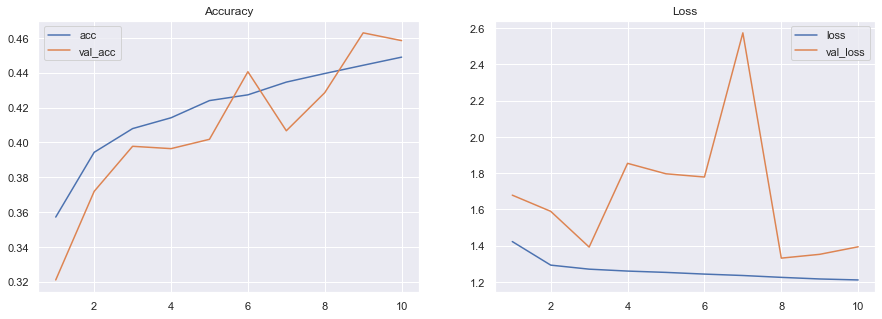

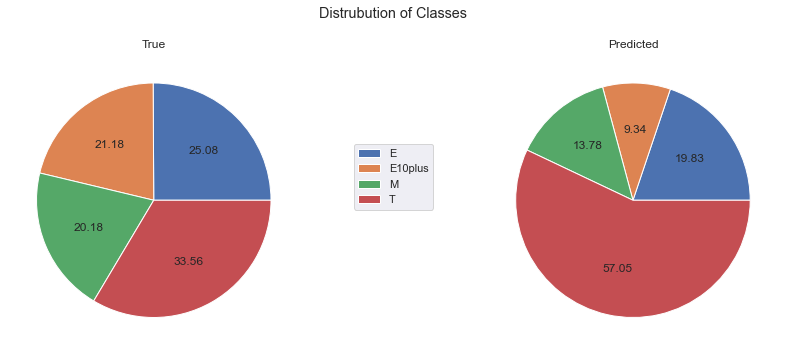

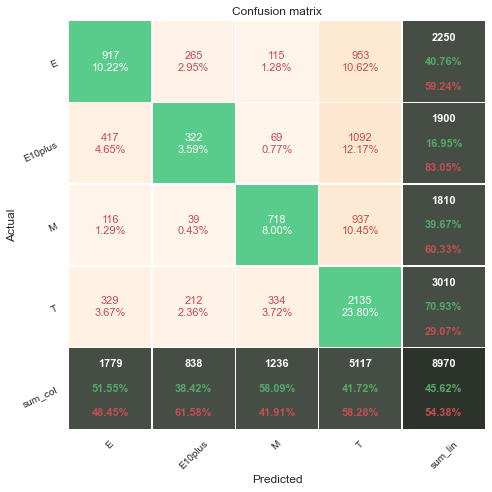

              precision    recall  f1-score   support

           E       0.52      0.41      0.46      2250
     E10plus       0.38      0.17      0.24      1900
           M       0.58      0.40      0.47      1810
           T       0.42      0.71      0.53      3010

    accuracy                           0.46      8970
   macro avg       0.47      0.42      0.42      8970
weighted avg       0.47      0.46      0.44      8970



<Figure size 432x288 with 0 Axes>

In [17]:
custom.evaluate(model_3, history_3, test_gen)

## Model 4 (With Class Weights)

In [18]:
model_4 = Sequential()

model_4.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',
                  activation='relu', input_shape=input_shape))
model_4.add(Conv2D(32, (3,3), activation='relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling2D((2,2)))
model_4.add(Dropout(0.2))

model_4.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model_4.add(Conv2D(64, (3,3), activation='relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling2D((2,2)))
model_4.add(Dropout(0.2))

model_4.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model_4.add(Conv2D(128, (3,3), activation='relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling2D((2,2)))
model_4.add(Dropout(0.2))

model_4.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model_4.add(Conv2D(256, (3,3), activation='relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling2D((2,2)))
model_4.add(Dropout(0.2))

model_4.add(Flatten())
model_4.add(Dense(512, activation='relu'))
model_4.add(Dropout(0.2))
model_4.add(Dense(4, activation='softmax'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4)

model_4.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 222, 222, 32)      9248      
_________________________________________________________________
batch_normalization_4 (Batch (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 111, 111, 64)      18496     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 109, 109, 64)     

In [19]:
class_counts = [11240, 9480, 15070, 9040]
class_weights = {x:15070/y for x,y in enumerate(class_counts)}

In [20]:
history_4 = model_4.fit(train_gen,
                        epochs=10,
                        validation_data=val_gen,
                        callbacks=init_callbacks(4),
                        class_weight=class_weights)

Epoch 1/10
1051/1051 [==============================] - 269s 255ms/step - loss: 2.5274 - acc: 0.3383 - val_loss: 1.4415 - val_acc: 0.3879

Epoch 00001: val_loss improved from inf to 1.44147, saving model to best_model_4.h5
Epoch 2/10
1051/1051 [==============================] - 264s 251ms/step - loss: 1.8271 - acc: 0.3778 - val_loss: 1.5020 - val_acc: 0.3826

Epoch 00002: val_loss did not improve from 1.44147
Epoch 3/10
1051/1051 [==============================] - 266s 253ms/step - loss: 1.8020 - acc: 0.3903 - val_loss: 1.3500 - val_acc: 0.4147

Epoch 00003: val_loss improved from 1.44147 to 1.35003, saving model to best_model_4.h5
Epoch 4/10
1051/1051 [==============================] - 264s 251ms/step - loss: 1.7682 - acc: 0.4083 - val_loss: 1.3243 - val_acc: 0.4250

Epoch 00004: val_loss improved from 1.35003 to 1.32431, saving model to best_model_4.h5
Epoch 5/10
1051/1051 [==============================] - 264s 251ms/step - loss: 1.7523 - acc: 0.4159 - val_loss: 2.2937 - val_acc: 0.

281/281 [==============================] - 12s 41ms/step - loss: 1.3401 - acc: 0.4313
[1.340077519416809, 0.43132665753364563]


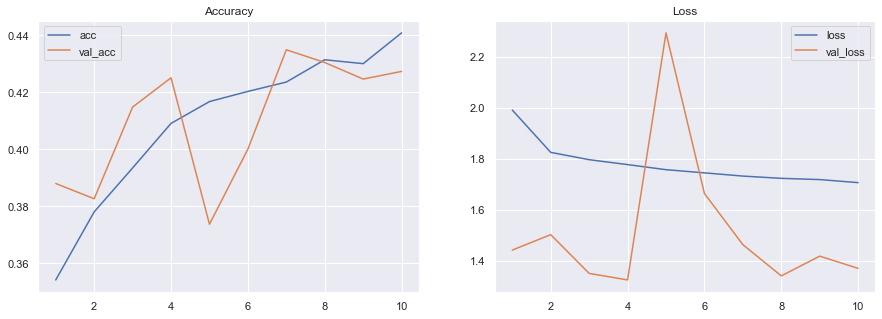

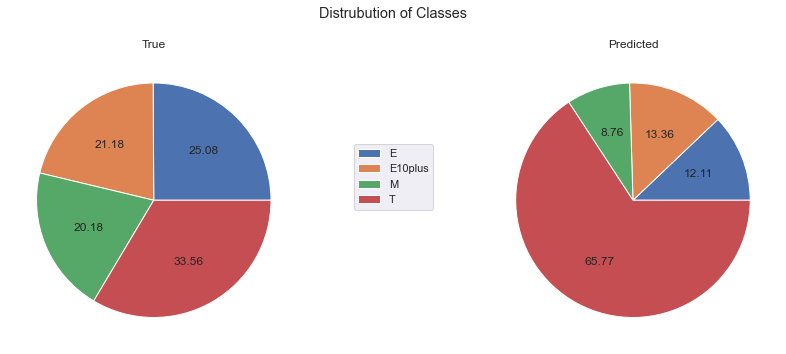

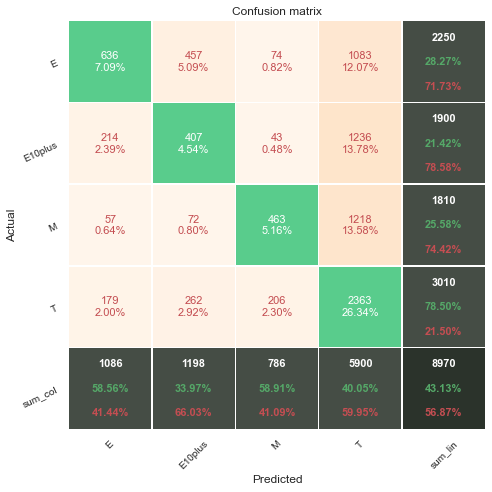

              precision    recall  f1-score   support

           E       0.59      0.28      0.38      2250
     E10plus       0.34      0.21      0.26      1900
           M       0.59      0.26      0.36      1810
           T       0.40      0.79      0.53      3010

    accuracy                           0.43      8970
   macro avg       0.48      0.38      0.38      8970
weighted avg       0.47      0.43      0.40      8970



<Figure size 432x288 with 0 Axes>

In [21]:
custom.evaluate(model_4, history_4, test_gen)

## Model 5 (Pretrained CNN)

In [22]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape=input_shape,
                   include_top=False)

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4, activation='softmax')(x)

model_5 = Model(base_model.input, x)

model_5.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['acc'])

model_5.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [23]:
history_5 = model_5.fit(train_gen,
                        validation_data=val_gen,
                        epochs=10,
                        callbacks=init_callbacks(5))

Epoch 1/10
1051/1051 [==============================] - 286s 266ms/step - loss: 1.3754 - acc: 0.3858 - val_loss: 1.1665 - val_acc: 0.4888

Epoch 00001: val_loss improved from inf to 1.16650, saving model to best_model_5.h5
Epoch 2/10
1051/1051 [==============================] - 275s 262ms/step - loss: 1.1907 - acc: 0.4548 - val_loss: 1.1523 - val_acc: 0.4996

Epoch 00002: val_loss improved from 1.16650 to 1.15234, saving model to best_model_5.h5
Epoch 3/10
1051/1051 [==============================] - 278s 264ms/step - loss: 1.1702 - acc: 0.4713 - val_loss: 1.1357 - val_acc: 0.4982

Epoch 00003: val_loss improved from 1.15234 to 1.13570, saving model to best_model_5.h5
Epoch 4/10
1051/1051 [==============================] - 275s 261ms/step - loss: 1.1570 - acc: 0.4824 - val_loss: 1.1513 - val_acc: 0.5009

Epoch 00004: val_loss did not improve from 1.13570
Epoch 5/10
1051/1051 [==============================] - 276s 262ms/step - loss: 1.1450 - acc: 0.4860 - val_loss: 1.1305 - val_acc: 0.

281/281 [==============================] - 42s 151ms/step - loss: 1.1269 - acc: 0.5148
[1.1268647909164429, 0.5148271918296814]


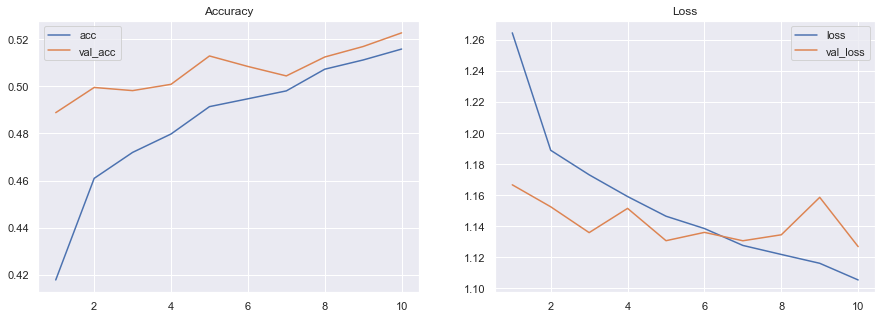

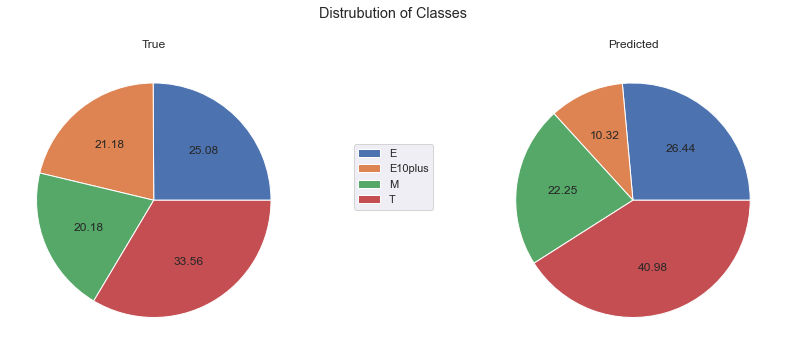

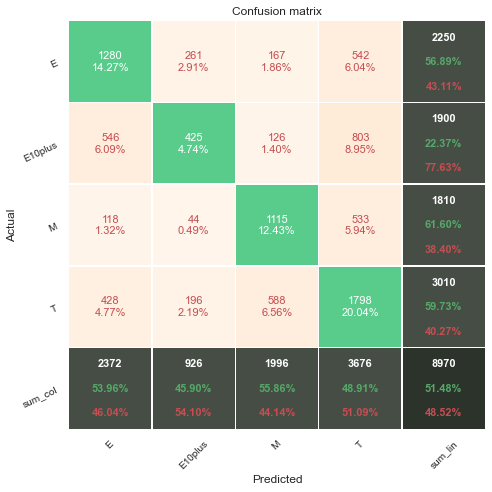

              precision    recall  f1-score   support

           E       0.54      0.57      0.55      2250
     E10plus       0.46      0.22      0.30      1900
           M       0.56      0.62      0.59      1810
           T       0.49      0.60      0.54      3010

    accuracy                           0.51      8970
   macro avg       0.51      0.50      0.49      8970
weighted avg       0.51      0.51      0.50      8970



<Figure size 432x288 with 0 Axes>

In [24]:
custom.evaluate(model_5, history_5, test_gen)

## Model 6 (Binary Classification)

In [25]:
train_gen_bin = train_data.flow_from_directory('images/binary/train', 
                                               target_size=(224,224),
                                               class_mode='binary')
val_gen_bin = val_data.flow_from_directory('images/binary/val', 
                                           target_size=(224,224),
                                           class_mode='binary')
test_gen_bin = test_data.flow_from_directory('images/binary/test',
                                             target_size=(224,224),
                                             class_mode='binary')

Found 33598 images belonging to 2 classes.
Found 2240 images belonging to 2 classes.
Found 8970 images belonging to 2 classes.


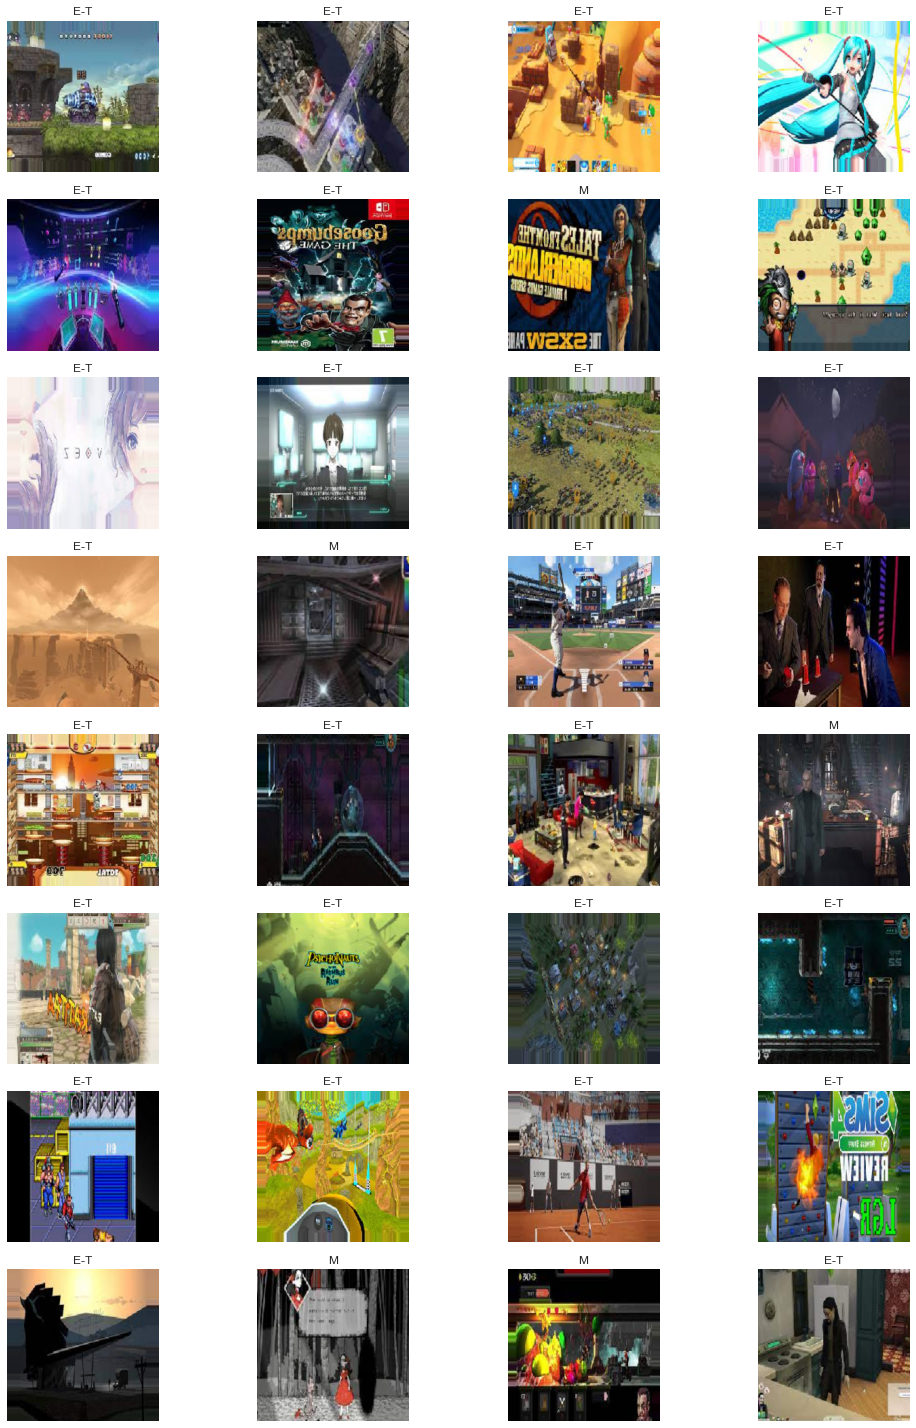

In [26]:
# View a batch of binary train data
img, labels = train_gen_bin.next()
classes = list(train_gen_bin.class_indices.keys())
str_labels = [classes[x] for x in labels.astype('int')]

plt.figure(figsize=(15,20))
for i in range(len(img)):
    plt.subplot(8,4,i+1)
    plt.title(f'{str_labels[i]}')
    plt.imshow(img[i])
    plt.axis('off')
plt.tight_layout()

In [27]:
base_model_bin = VGG16(include_top=False,
                       input_shape=input_shape)
for layer in base_model_bin.layers:
    layer.trainable = False
    
x = Flatten()(base_model_bin.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model_6 = Model(base_model_bin.input, x)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model_6.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['acc'])

model_6.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [28]:
history_6 = model_6.fit(train_gen_bin,
                        epochs=10,
                        validation_data=val_gen_bin,
                        callbacks=init_callbacks(6))

Epoch 1/10
1050/1050 [==============================] - 339s 322ms/step - loss: 0.4472 - acc: 0.8034 - val_loss: 0.3882 - val_acc: 0.8183

Epoch 00001: val_loss improved from inf to 0.38824, saving model to best_model_6.h5
Epoch 2/10
1050/1050 [==============================] - 267s 254ms/step - loss: 0.3952 - acc: 0.8221 - val_loss: 0.3793 - val_acc: 0.8254

Epoch 00002: val_loss improved from 0.38824 to 0.37931, saving model to best_model_6.h5
Epoch 3/10
1050/1050 [==============================] - 270s 257ms/step - loss: 0.3876 - acc: 0.8280 - val_loss: 0.3793 - val_acc: 0.8321

Epoch 00003: val_loss did not improve from 0.37931
Epoch 4/10
1050/1050 [==============================] - 266s 253ms/step - loss: 0.3792 - acc: 0.8324 - val_loss: 0.3821 - val_acc: 0.8188

Epoch 00004: val_loss did not improve from 0.37931
Epoch 5/10
1050/1050 [==============================] - 270s 257ms/step - loss: 0.3736 - acc: 0.8331 - val_loss: 0.3740 - val_acc: 0.8375

Epoch 00005: val_loss improved 

281/281 [==============================] - 40s 141ms/step - loss: 0.3641 - acc: 0.8433
[0.3640998303890228, 0.8432552814483643]


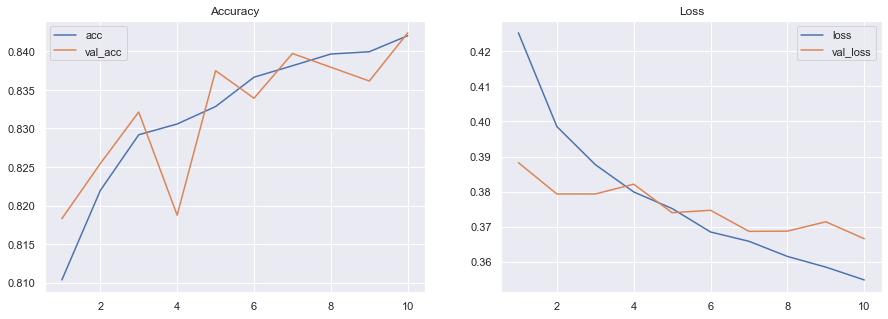

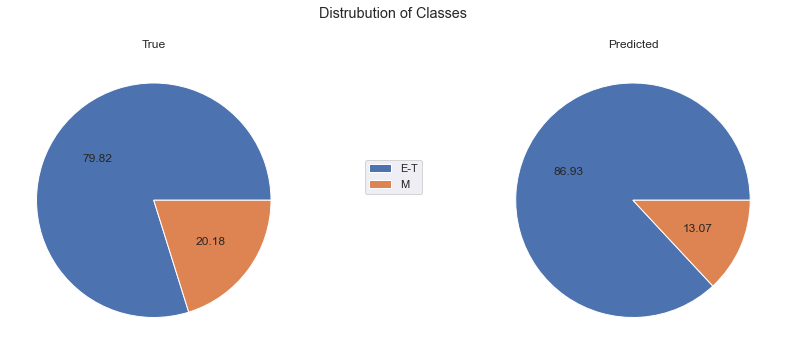

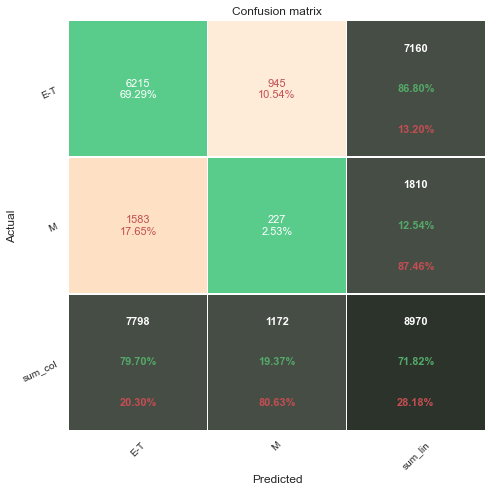

              precision    recall  f1-score   support

         E-T       0.80      0.87      0.83      7160
           M       0.19      0.13      0.15      1810

    accuracy                           0.72      8970
   macro avg       0.50      0.50      0.49      8970
weighted avg       0.68      0.72      0.69      8970



<Figure size 432x288 with 0 Axes>

In [29]:
custom.evaluate(model_6, history_6, test_gen_bin)

## Model 7 (Binary w/ Weights)

In [30]:
base_model_bin = VGG16(include_top=False,
                       input_shape=input_shape)
for layer in base_model_bin.layers:
    layer.trainable = False
    
x = Flatten()(base_model_bin.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model_7 = Model(base_model_bin.input, x)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model_7.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['acc'])

model_7.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [31]:
total = train_gen_bin.classes.shape[0]
ones = train_gen_bin.classes.sum()
zeroes = total - ones

print(zeroes, ones)

26818 6780


In [32]:
class_weights = {x:zeroes/y for x,y in enumerate([zeroes, ones])}
class_weights

{0: 1.0, 1: 3.955457227138643}

In [33]:
history_7 = model_7.fit(train_gen_bin,
                        validation_data=val_gen_bin,
                        epochs=10,
                        class_weight=class_weights,
                        callbacks=init_callbacks(7))

Epoch 1/10
1050/1050 [==============================] - 271s 258ms/step - loss: 0.9824 - acc: 0.6863 - val_loss: 0.5940 - val_acc: 0.6960

Epoch 00001: val_loss improved from inf to 0.59404, saving model to best_model_7.h5
Epoch 2/10
1050/1050 [==============================] - 268s 255ms/step - loss: 0.8501 - acc: 0.7408 - val_loss: 0.5581 - val_acc: 0.7250

Epoch 00002: val_loss improved from 0.59404 to 0.55813, saving model to best_model_7.h5
Epoch 3/10
1050/1050 [==============================] - 266s 253ms/step - loss: 0.8261 - acc: 0.7523 - val_loss: 0.5549 - val_acc: 0.7286

Epoch 00003: val_loss improved from 0.55813 to 0.55486, saving model to best_model_7.h5
Epoch 4/10
1050/1050 [==============================] - 268s 255ms/step - loss: 0.8184 - acc: 0.7523 - val_loss: 0.4747 - val_acc: 0.7893

Epoch 00004: val_loss improved from 0.55486 to 0.47473, saving model to best_model_7.h5
Epoch 5/10
1050/1050 [==============================] - 270s 257ms/step - loss: 0.7866 - acc: 0.

281/281 [==============================] - 40s 142ms/step - loss: 0.4700 - acc: 0.7797
[0.4700274169445038, 0.7797101736068726]


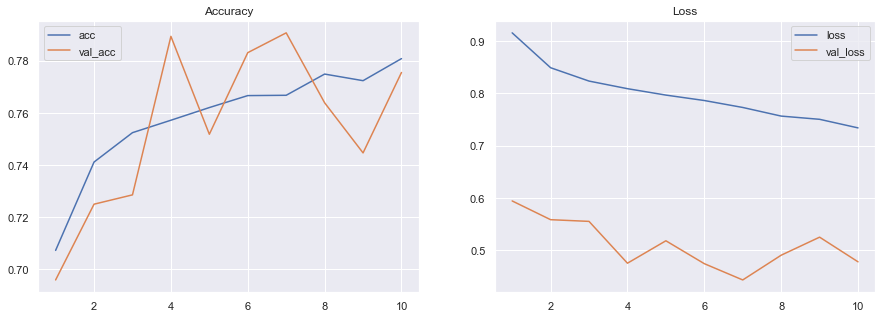

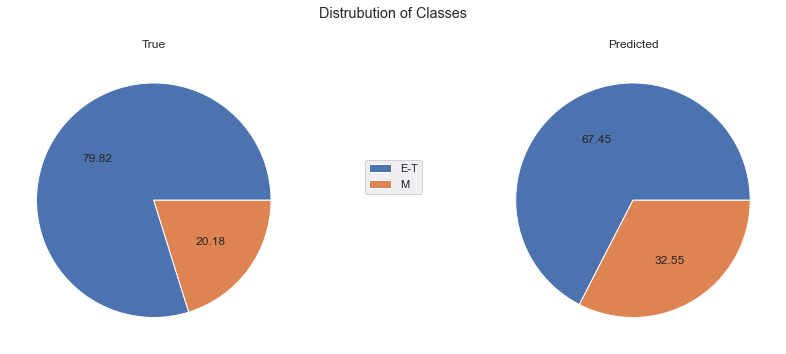

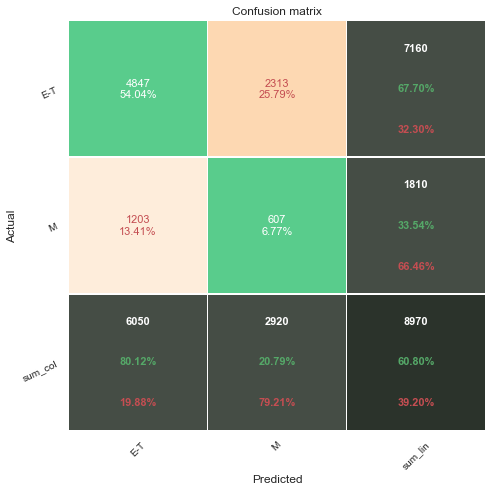

              precision    recall  f1-score   support

         E-T       0.80      0.68      0.73      7160
           M       0.21      0.34      0.26      1810

    accuracy                           0.61      8970
   macro avg       0.50      0.51      0.50      8970
weighted avg       0.68      0.61      0.64      8970



<Figure size 432x288 with 0 Axes>

In [34]:
custom.evaluate(model_7, history_7, test_gen_bin)

# iNterpret

In [35]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import os
import numpy as np

In [36]:
model = VGG16()
ixs = [2, 5, 9, 13, 17]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)

Image from: BloodRayne Betrayal
Rated: T


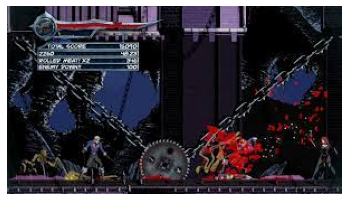

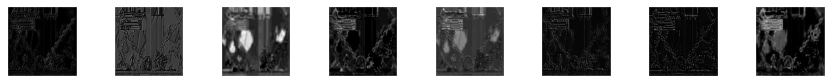

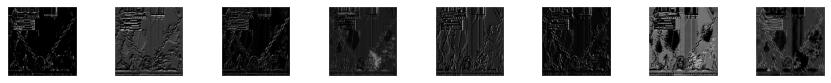

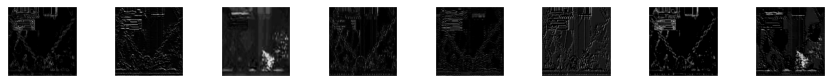

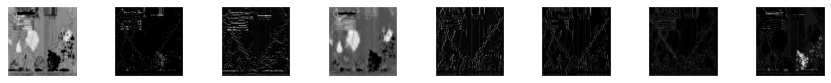

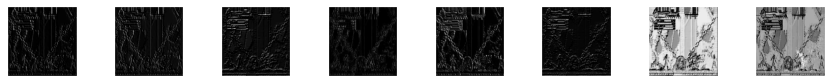

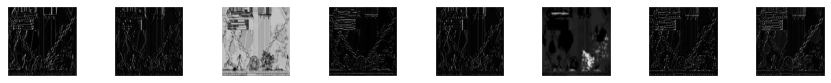

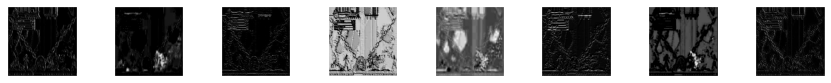

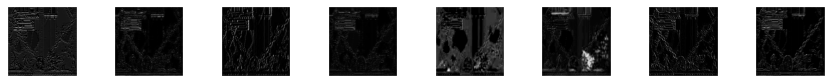

------------------------------------------------------------------------------------------------------------


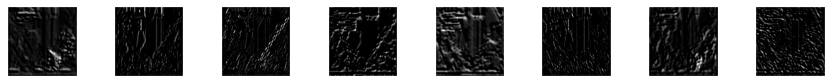

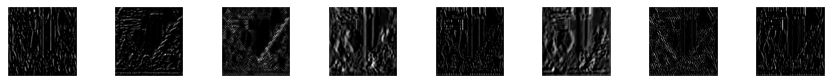

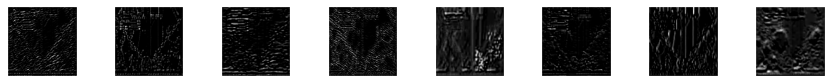

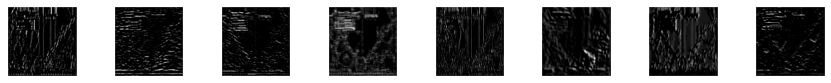

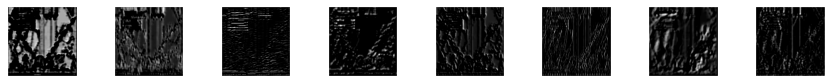

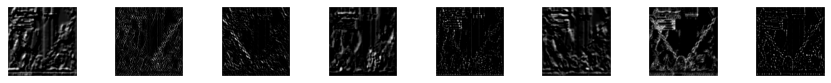

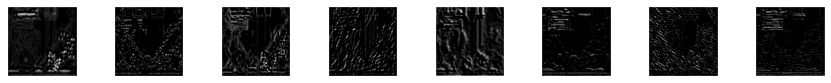

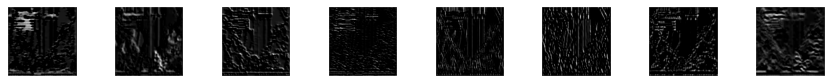

------------------------------------------------------------------------------------------------------------


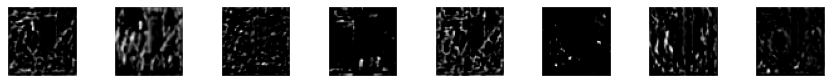

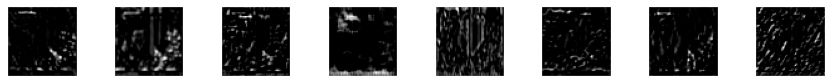

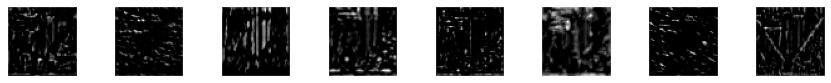

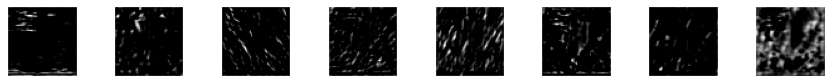

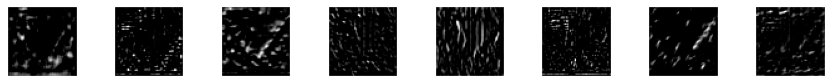

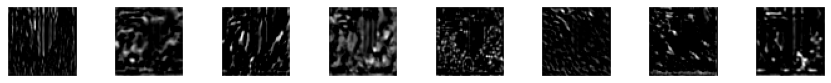

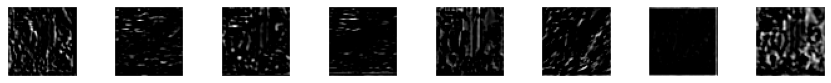

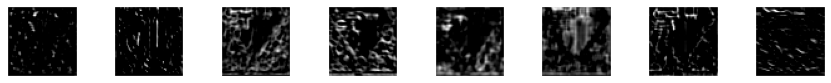

------------------------------------------------------------------------------------------------------------


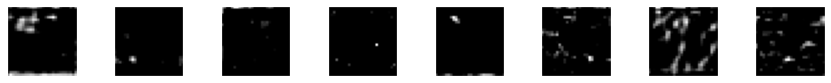

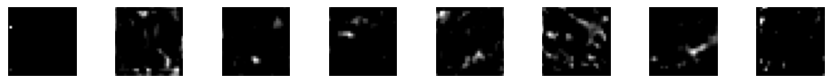

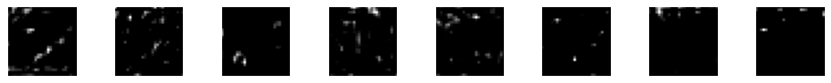

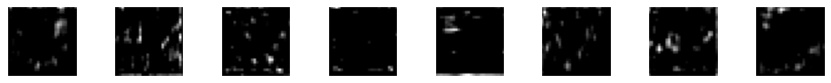

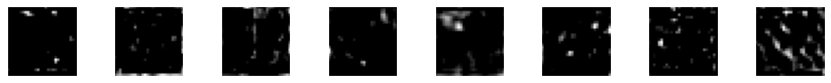

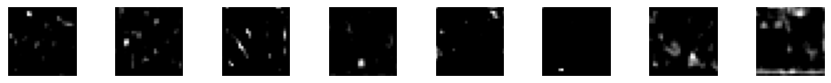

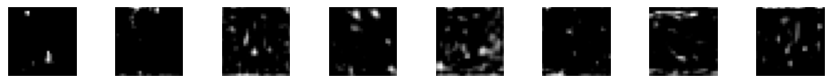

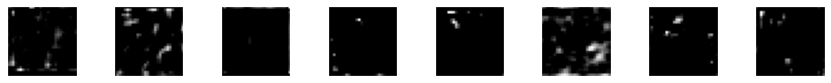

------------------------------------------------------------------------------------------------------------


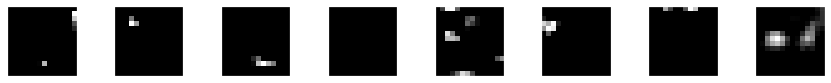

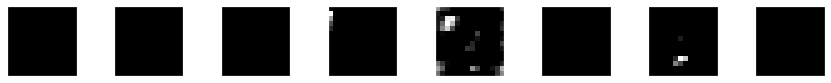

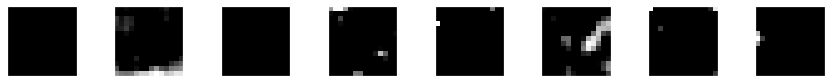

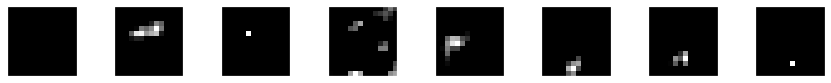

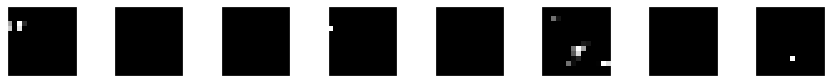

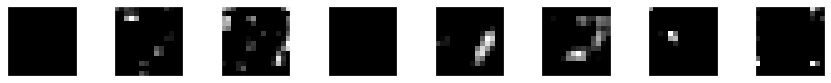

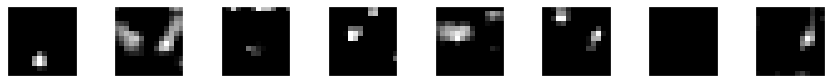

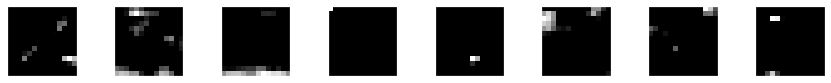

------------------------------------------------------------------------------------------------------------


In [37]:
random_rating = np.random.choice(['E', 'E10plus', 'M', 'T'])
random_image = np.random.choice(os.listdir('images/' + random_rating))
random_path = 'images/' + random_rating + '/' + random_image

test_img = load_img(random_path, target_size=(224,224))
test_img = img_to_array(test_img)
test_img = np.expand_dims(test_img, axis=0)
test_img = preprocess_input(test_img)

feature_maps = model.predict(test_img)

square = 8
print(f'Image from: {random_image[:-6]}')
print(f'Rated: {random_rating}')
plt.imshow(load_img(random_path))
plt.axis('off')
for fmap in feature_maps:
    ix = 1
    for _ in range(square):
        plt.figure(figsize=(15,12))
        for _ in range(square):
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(fmap[0,:,:,ix-1], cmap='gray')
            ix += 1
    plt.show()
    print('-----' * 21 + '---')

In [38]:
model_5.predict(test_img)

array([[1.000000e+00, 0.000000e+00, 0.000000e+00, 1.554404e-25]],
      dtype=float32)